In [36]:
#!git clone https://github.com/Hong7Cong/RAFT_clone

In [1]:
import argparse
from timesformer.models.vit import MOOSE
import torch
parser = argparse.ArgumentParser()

parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--path', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
parser.add_argument('--MODEL.VISUAL_MODEL', type=str, default='default_model')
parser.add_argument('--MODEL.FUSION_MODE', type=str, default='concat')
parser.add_argument('--MODEL.NUM_CLASSES', type=int, default='400')
raft_args = parser.parse_args(['--model', '/data2/hongn/RAFT/models/raft-things.pth', 
                        '--path', 'New folder'])

from types import SimpleNamespace

cfg = SimpleNamespace(
    MODEL=SimpleNamespace(
        VISUAL_MODEL="dinov2",
        FUSION_MODE="biconcat",
        NUM_CLASSES=400
    ),
    DATA=SimpleNamespace(
        TRAIN_CROP_SIZE=224,
    )
)

model_infos = torch.load('/data2/hongn/TimePSFormer/checkpoints/moose_biconcat_dinov2_8frame_maskarrow/checkpoints/checkpoint_epoch_00011.pyth', weights_only=False, map_location='cpu')
model = MOOSE(cfg, raft_args)
model.load_state_dict(model_infos['model_state'], strict=False)
model.eval()

/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Using cache found in /home/hongn/.cache/torch/hub/facebookresearch_dinov2_main
/home/hongn/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/hongn/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is 

MOOSE(
  (moose_encoder): MOOSE_Encoder(
    (motion_model): RAFT(
      (fnet): BasicEncoder(
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (relu1): ReLU(inplace=True)
        (layer1): Sequential(
          (0): ResidualBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (relu): ReLU(inplace=True)
            (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          )
          (1): ResidualBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [2]:
import av
import numpy as np
import torch
from IPython.core.pylabtools import figsize


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    start_idx = 2
    end_idx = start_idx + converted_len
    
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

indices = sample_frame_indices(8, 3)
file_path = "/data1/hongn/haa500/video/golf_swing/golf_swing_001.mp4"
container = av.open(file_path)
indices

array([ 2,  5,  8, 12, 15, 19, 22, 25])

In [3]:
#indices = [ 11,  34,  56,  79, 101, 124, 147, 169]
video = read_video_pyav(container, indices)

In [4]:
video.shape

(8, 720, 1280, 3)

In [5]:
# video_tensor.shape

In [6]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
# def load_image_from_uint8array(img):
#     img = torch.from_numpy(img).permute(0, 3, 1, 2).float()
#     return img[None]

video_tensor = video[0]
video_tensor = torch.tensor(video).float()
# video_tensor = video_tensor.permute(0, 3, 1, 2)  # Shape: (num_frames, 3, height, width)
# video_tensor = video_tensor.unsqueeze(0)  # Shape: (1, num_frames, 3, height, width)
# video_tensor_resized = F.interpolate(video_tensor.view(-1, 3, video_tensor.shape[3], video_tensor.shape[4]), 
#                                      size=(224, 224), 
#                                      mode='bilinear', 
#                                      align_corners=False)

from torchvision import transforms
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(256, 320)),
    transforms.CenterCrop(224),
])
norm = transforms.Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225))
video_tensor_4plot = [T(vid) for vid in video]
video_tensor_resized = [norm(T(vid)) for vid in video]
video_tensor_resized =  torch.stack(video_tensor_resized)
video_tensor_4plot =  torch.stack(video_tensor_4plot)
# num_frames = 8
video_tensor_resized = video_tensor_resized.permute(1, 0, 2, 3).unsqueeze(0)
print("Resized Video tensor shape:", video_tensor_resized.shape)

Resized Video tensor shape: torch.Size([1, 3, 8, 224, 224])


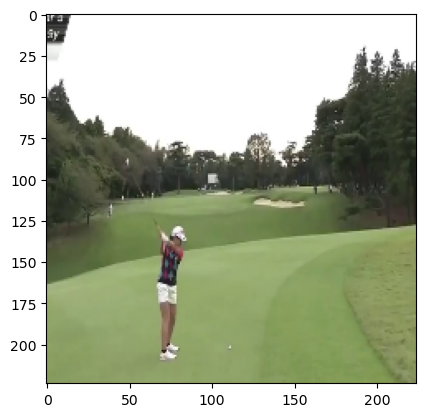

In [7]:
from PIL import Image
demo_array = np.moveaxis(video_tensor_4plot[0].numpy()*255, 0, -1)
# Image.fromarray(demo_array.astype(np.uint8))
plt.imshow(demo_array.astype(np.uint8))

In [8]:
class Visualizer():
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.attn = []
        self.query = []
        self.key = []
        self.value = []
        
    def get_attn(self, module, input, output):
        self.attn.append(output.detach().cpu())
        
    def get_query(self, module, input, output):
        if isinstance(output, tuple):
            for out in output:
                if isinstance(out, torch.Tensor):
                    self.query.append(out.detach().cpu())
                else:
                    self.query.append(out)
        else:
            self.query.append(output.detach().cpu())
    
    def get_key(self, module, input, output):
        if isinstance(output, tuple):
            for out in output:
                if isinstance(out, torch.Tensor):
                    self.key.append(out.detach().cpu())
                else:
                    self.key.append(out)
        else:
            self.key.append(output.detach().cpu())
    
    def get_value(self, module, input, output):
        if isinstance(output, tuple):
            for out in output:
                if isinstance(out, torch.Tensor):
                    self.value.append(out.detach().cpu())
                else:
                    self.value.append(out)
        else:
            self.value.append(output.detach().cpu())
    
    def remove_hook(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        
    def __call__(self, input):
        self.model.eval()
        self.attn = []
        with torch.no_grad():
            for name, m in self.model.named_modules():
                for i in range (12):
                    if f"moose_encoder.visual_model.blocks.{i}.attn.attn_drop" in name:
                        self.hooks.append(m.register_forward_hook(self.get_attn))
                    
                if "joint_cross_attn.to_qk" in name:
                    self.hooks.append(m.register_forward_hook(self.get_query))
                
                if "joint_cross_attn.context_to_qk" in name:
                    self.hooks.append(m.register_forward_hook(self.get_key))
                
                if  name == "motion_feature_extractor.blocks.11.attn.attn_drop":
                    self.hooks.append(m.register_forward_hook(self.get_value))
                
            _ = self.model(input)
        self.remove_hook()
        return self.attn, self.query ,self.key, self.value

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
video_tensor_resized = video_tensor_resized.to(device)
device

'cuda'

In [10]:
a = Visualizer(model)
attention, Q, K, V = a(video_tensor_resized)

/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673730874951/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

for o in range(len(attention)):
    attn = attention[o].detach().cpu()  # shape: (B, num_heads, 197, 197)
    B, num_heads, seq_len, _ = attn.shape
    heatmaps = []
    top3_points_list = []

    # for i in range(B):
    #     # Lấy attention của token CLS (index 0) đến các patch tokens (indices 1:197)
    #     # Kết quả có shape (num_heads, 196)
    #     attn_frame = attn[i, :, : 5 , 5:]
    #     # Tính trung bình attention qua các head -> shape: (196,)
    #     attn_avg = attn_frame.mean(dim=0)
    #     attn_avg = attn_avg.mean(dim=0)

    #     # # Lấy top-3 chỉ số với giá trị attention cao nhất
    #     # topk_values, topk_indices = torch.topk(attn_avg, k=3)
    #     # top3_coords = []
    #     # for idx in topk_indices:
    #     #     idx = int(idx.item())
    #     #     # Chuyển chỉ số từ vector 196 phần tử sang tọa độ trên lưới 14x14
    #     #     row = idx // 16
    #     #     col = idx % 16
    #     #     top3_coords.append((col, row))  # (x, y) = (col, row)
    #     # top3_points_list.append(top3_coords)

    #     # Chuẩn hóa attention về khoảng [0, 1]
    #     attn_norm = (attn_avg - attn_avg.min()) / (attn_avg.max() - attn_avg.min() + 1e-8)
    #     # Reshape thành lưới 14 x 14
    #     attn_grid = attn_norm.reshape(16, 16)
    #     attn_grid = attn_grid.unsqueeze(0).unsqueeze(0)
    #     # Phóng to (interpolate) lên kích thước 224 x 224
    #     attn_up = F.interpolate(attn_grid, size=(224, 224), mode="bilinear", align_corners=False)
    #     attn_up = attn_up.squeeze().numpy()  # shape: (224, 224)
    #     heatmaps.append(attn_up)

    # overlay_images = []

    # for i in range(B):
    #     frame = video[i]  # shape: (H, W, 3) (RGB)
    #     # Chuyển heatmap sang 8-bit [0, 255]
    #     heatmap = (heatmaps[i] * 255).astype(np.uint8)
    #     # Áp dụng colormap (COLORMAP_JET) cho heatmap
    #     heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #     # Resize heatmap_color để khớp với kích thước của frame
    #     heatmap_color_resized = cv2.resize(heatmap_color, (frame.shape[1], frame.shape[0]))
    #     # Chuyển frame từ RGB sang BGR (theo chuẩn của OpenCV)
    #     frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    #     # Trộn ảnh gốc với heatmap
    #     overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0)

    #     # # Vẽ lên overlay 3 điểm mà CLS token chú ý nhiều nhất
    #     # # Vì lưới gốc là 14x14, mỗi ô có kích thước tương ứng với: 224/14 = 16 (trong không gian heatmap 224x224)
    #     # # Ta cần scale tọa độ từ không gian 224x224 sang kích thước frame (overlay) hiện tại.
    #     # # Tính tỉ lệ scale dựa trên frame kích thước (giả sử heatmap ban đầu có kích thước 224x224)
    #     # scale_x = frame.shape[1] / 224.0
    #     # scale_y = frame.shape[0] / 224.0
    #     # factor = 224 / 16.0  # kích thước mỗi ô trên heatmap 224x224
    #     # 
    #     # for (col, row) in top3_points_list[i]:
    #     #     # Tọa độ trung tâm của ô trong không gian heatmap 224x224
    #     #     center_x = (col + 0.5) * factor
    #     #     center_y = (row + 0.5) * factor
    #     #     # Scale lên kích thước của overlay image
    #     #     center_x = int(center_x * scale_x)
    #     #     center_y = int(center_y * scale_y)
    #     #     # Vẽ vòng tròn (màu đỏ, bán kính 5, đầy đủ)
    #     #     #cv2.circle(overlay, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)

    #     overlay_images.append(overlay)

    # # Hiển thị kết quả overlay cho từng frame
    # for i in range(len(overlay_images)):
    #     plt.figure(figsize=(6, 6))
    #     plt.imshow(cv2.cvtColor(overlay_images[i], cv2.COLOR_BGR2RGB))
    #     plt.axis("off")
    #     plt.show()

In [12]:
attention_weights = []
for i in range(len(Q)):
    q = Q[i]  # shape: [1, 197, 768]
    k = K[i]  # shape: [1, 197, 768]
    v = V[i]  # shape: [1, 197, 768]

    scale = q.size(-1)**0.5
    att_weight = q@k.transpose(-2, -1) / scale
    att_weight = F.softmax(att_weight, dim=-1)
    attention_weights.append(att_weight)

In [13]:
attn[:, 0, 1:].shape

torch.Size([8, 260, 261])

In [14]:
torch.mean(attn, axis=0)[0, 1:].shape

torch.Size([260, 261])

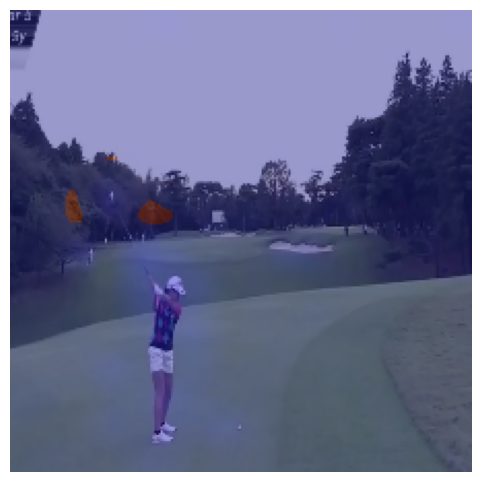

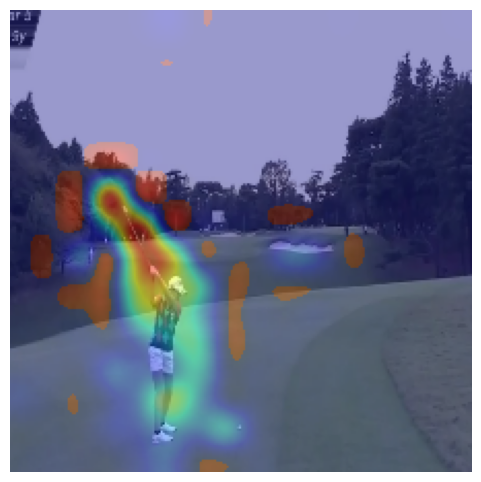

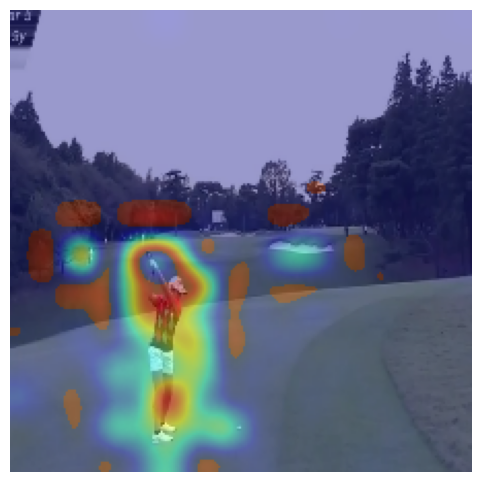

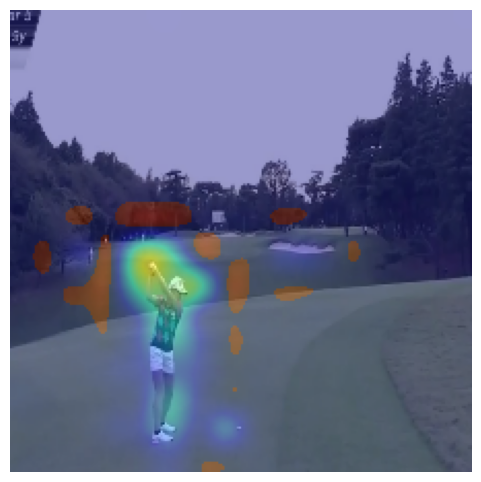

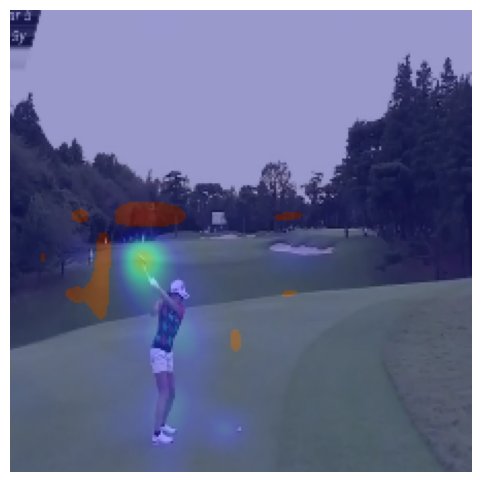

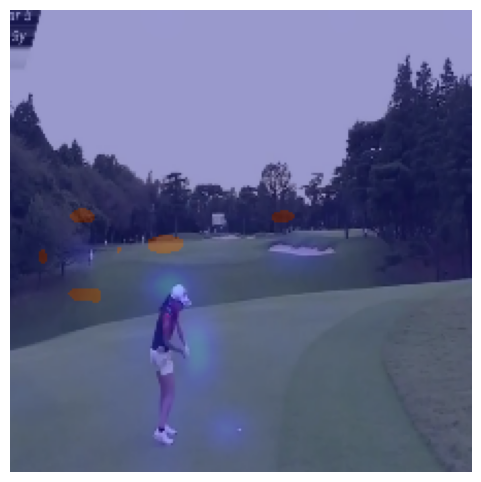

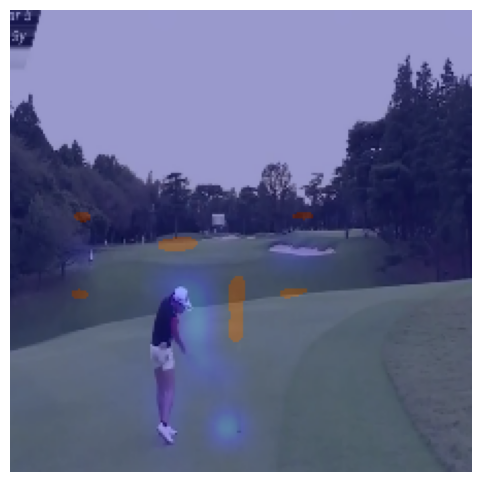

In [15]:
import cv2
import matplotlib.pyplot as plt

overlay_images = []
hm = []

for o in range (len(attention_weights)):
    attn = attention_weights[o].detach().cpu()  # shape: (B, num_heads, 197, 197)
    B, seq_len, _ = attn.shape
    heatmaps = []
    top3_points_list = []
    
    for i in range(B):
        # Lấy attention của token CLS (index 0) đến các patch tokens (indices 1:197)
        # Kết quả có shape (num_heads, 196)
        attn_avg = attn[i, 1:, 0]
        # Tính trung bình attention qua các head -> shape: (196,)
        
        # Lấy top-3 chỉ số với giá trị attention cao nhất
        topk_values, topk_indices = torch.topk(attn_avg, k=3)
        top3_coords = []
        for idx in topk_indices:
            idx = int(idx.item())
            # Chuyển chỉ số từ vector 196 phần tử sang tọa độ trên lưới 14x14
            row = idx // 14
            col = idx % 14
            top3_coords.append((col, row))  # (x, y) = (col, row)
        top3_points_list.append(top3_coords)
        
        # Chuẩn hóa attention về khoảng [0, 1]
        attn_norm = (attn_avg - attn_avg.min()) / (attn[:, 1:, 0].max() - attn[:, 1:, 0].min() + 1e-8)#[Hong Modify]
        # Reshape thành lưới 14 x 14
        attn_grid = attn_norm.reshape(16, 16)
        attn_grid = attn_grid.unsqueeze(0).unsqueeze(0)
        # Phóng to (interpolate) lên kích thước 224 x 224
        attn_up = F.interpolate(attn_grid, size=(224, 224), mode="bicubic", align_corners=False)
        attn_up = attn_up.squeeze().numpy()  # shape: (224, 224)
        heatmaps.append(attn_up)
    
    for i in range(B):
        temp = np.moveaxis(video_tensor_4plot[i].cpu().numpy()*255, 0, -1).astype(np.uint8)
        frame = temp# video[o + 1]  # shape: (H, W, 3) (RGB)
        # Chuyển heatmap sang 8-bit [0, 255]
        heatmap = (heatmaps[i] * 255).astype(np.uint8)
        # Áp dụng colormap (COLORMAP_JET) cho heatmap
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        # Resize heatmap_color để khớp với kích thước của frame
        heatmap_color_resized = cv2.resize(heatmap_color, (frame.shape[1], frame.shape[0]))
        hm.append(heatmap_color_resized)
        # Chuyển frame từ RGB sang BGR (theo chuẩn của OpenCV)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        # Trộn ảnh gốc với heatmap
        overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0)
        
        # Vẽ lên overlay 3 điểm mà CLS token chú ý nhiều nhất
        # Vì lưới gốc là 14x14, mỗi ô có kích thước tương ứng với: 224/14 = 16 (trong không gian heatmap 224x224)
        # Ta cần scale tọa độ từ không gian 224x224 sang kích thước frame (overlay) hiện tại.
        # Tính tỉ lệ scale dựa trên frame kích thước (giả sử heatmap ban đầu có kích thước 224x224)
        scale_x = frame.shape[1] / 224.0
        scale_y = frame.shape[0] / 224.0
        factor = 224 / 14.0  # kích thước mỗi ô trên heatmap 224x224
        
        for (col, row) in top3_points_list[i]:
            # Tọa độ trung tâm của ô trong không gian heatmap 224x224
            center_x = (col + 0.5) * factor
            center_y = (row + 0.5) * factor
            # Scale lên kích thước của overlay image
            center_x = int(center_x * scale_x)
            center_y = int(center_y * scale_y)
            # Vẽ vòng tròn (màu đỏ, bán kính 5, đầy đủ)
        
        overlay_images.append(overlay)
    
    # Hiển thị kết quả overlay cho từng frame
for i in range(len(overlay_images)):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [16]:
temp.shape

(224, 224, 3)

In [17]:
from torchvision.transforms import functional as FS
from torchvision.models.optical_flow import raft_large
import torch

def compute_optical_flow(frame1, frame2, model, device):
    # Convert frames to tensors and move them to the device
    frame1_tensor = FS.to_tensor(frame1).unsqueeze(0).to(device)  # Shape: [1, 3, H, W] - 3 is the RGB Channels
    frame2_tensor = FS.to_tensor(frame2).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

    # Resize frames to be divisible by 8
    _, _, h, w = frame1_tensor.shape
    h = (h // 8) * 8  # Make height divisible by 8
    w = (w // 8) * 8  # Make width divisible by 8
    frame1_tensor = FS.resize(frame1_tensor, (h, w))
    frame2_tensor = FS.resize(frame2_tensor, (h, w))

    # Perform inference
    with torch.no_grad():
        flow = model(frame1_tensor, frame2_tensor)[0]  # Shape: [1, 2, H, W]

    # Process the flow result
    flow = flow[0]  # Remove the batch dimension. Shape: [2, H, W] - 2 is the (u, v) dimension
    flow = flow.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, 2] and NumPy format
    return flow

import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_optical_flow_arrow(optical_flow, start_frame, scale):
    # Convert flow values back to NumPy array
    flow = np.array(optical_flow)  # Shape: [H, W, 2]

    # Create a copy of the start frame for visualization with flow arrows
    vis_frame_with_arrows = start_frame.copy()
    vis_frame_with_arrows= cv2.cvtColor(vis_frame_with_arrows, cv2.COLOR_BGR2RGB)

    H, W, _ = flow.shape # Get flow dimensions

    # Draw optical flow arrows on the start frame
    for y in range(0, H, 12):  # Sample every 100th pixel
        for x in range(0, W, 12):
            dx, dy = flow[y, x]  # Flow vector at (x, y)
            start_point = (x, y)
            end_point = (int(x + scale * dx), int(y + scale * dy)) # may adjust scale for better visualization
            cv2.arrowedLine(vis_frame_with_arrows, start_point, end_point, (255, 255, 255), thickness=2, tipLength=0.2)

    # Convert BGR to RGB for visualization with Matplotlib
    vis_frame_with_arrows_rgb = cv2.cvtColor(vis_frame_with_arrows, cv2.COLOR_BGR2RGB)

    plt.imshow(vis_frame_with_arrows_rgb)
    plt.axis("off")
    plt.show()

/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2


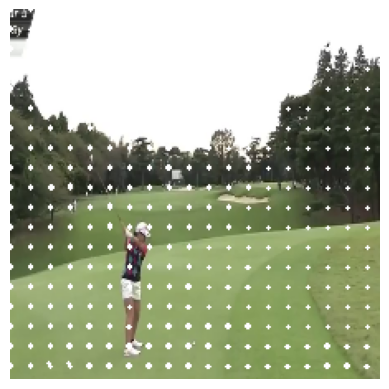

5


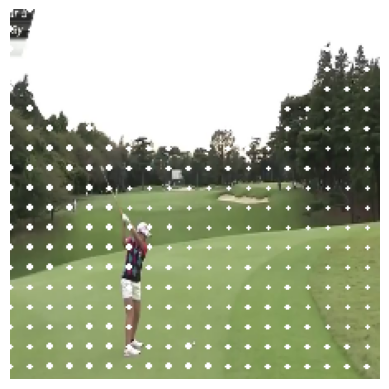

8


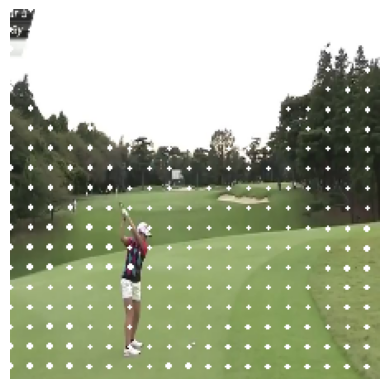

12


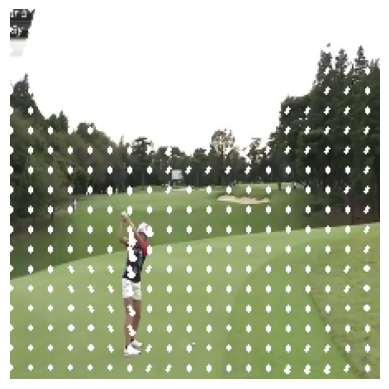

15


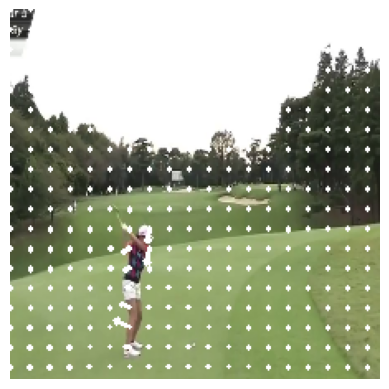

19


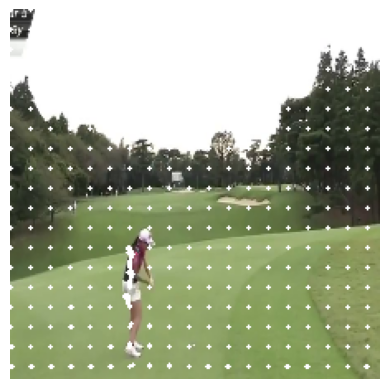

22


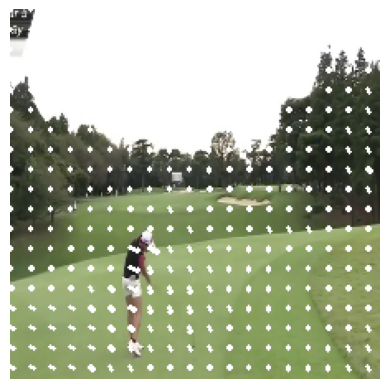

In [18]:
raft = raft_large(pretrained=True, progress=True).eval().to(device)  # Load raft_large model

frames = []
for i in range(len(video)):
    frames.append(np.moveaxis(video_tensor_4plot[i].cpu().numpy()*255, 0, -1).astype(np.uint8))
for i in range(len(video) - 1):
    print(indices[i])
    # frame = np.moveaxis(video_tensor_4plot[i].cpu().numpy()*255, 0, -1).astype(np.uint8)
    flow = compute_optical_flow(frames[i], frames[i + 1], raft, device)
    visualize_optical_flow_arrow(flow, frames[i], scale=4)

In [19]:
v = V[0][0]
v.shape

torch.Size([3, 257, 257])

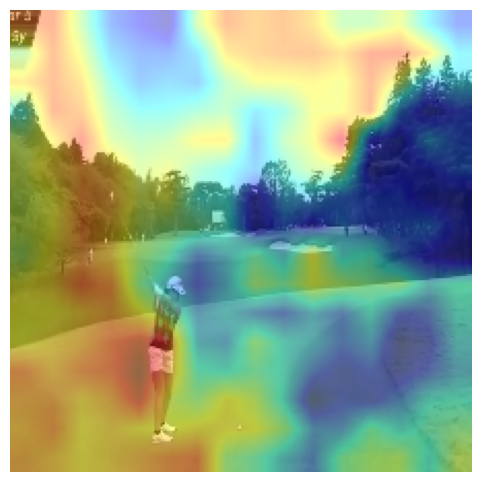

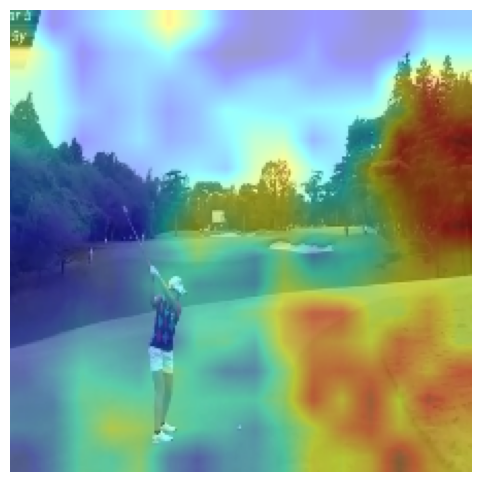

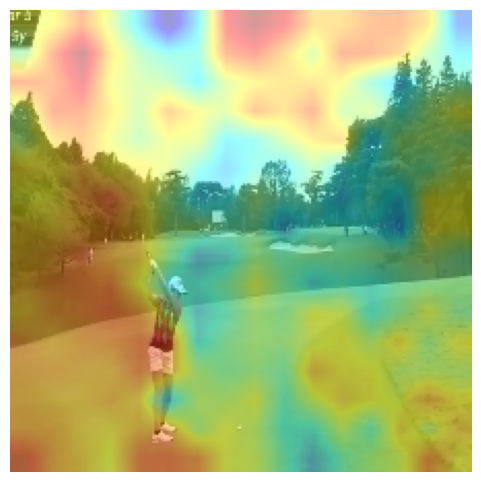

In [20]:
import torch.nn.functional as F
for o in range(3):
    attn = v[o].detach().cpu()  # shape: (B, num_heads, 197, 197)
    attn_frame = attn[0, 1:]
    attn_avg = attn_frame
    attn_norm = (attn_avg - attn_avg.min()) / (attn_avg.max() - attn_avg.min() + 1e-8)
    # Reshape thành lưới 14 x 14
    attn_grid = attn_norm.reshape(16, 16)
    attn_grid = attn_grid.unsqueeze(0).unsqueeze(0)
    # Phóng to (interpolate) lên kích thước 224 x 224
    attn_up = F.interpolate(attn_grid, size=(224, 224), mode="bilinear", align_corners=False)
    attn_up = attn_up.squeeze().numpy()  # shape: (224, 224)

    frame = frames[o]  # shape: (H, W, 3) (RGB)
    heatmap = (attn_up * 255).astype(np.uint8)
    # Áp dụng colormap (COLORMAP_JET) cho heatmap
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Resize heatmap_color để khớp với kích thước của frame
    heatmap_color_resized = cv2.resize(heatmap_color, (frame.shape[1], frame.shape[0]))
    # Chuyển frame từ RGB sang BGR (theo chuẩn của OpenCV)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [21]:
attn.shape

torch.Size([257, 257])

In [22]:
# top_query = np.array(topk_indices)
# query = torch.tensor(top_query, dtype=torch.long)
# query

In [23]:
# attn1 = attention_weights[-1][:, 1:, 1:]
# attn1 = attn1[0, query, :]
# max_val, idx_ = attn1.max(dim=-1)
# idx_ = idx_.cpu().numpy()
# idx_

In [24]:
# model_input_size = (224, 224) 
# patch_grid_size = 14
# patch_size_model = model_input_size[0] // patch_grid_size 
# 
# def compute_patch_centers(token_indices, grid_size=14, patch_size=16):
#     centers = []
#     for idx in token_indices:
#         row = idx // grid_size
#         col = idx % grid_size
#         x = int(col * patch_size + patch_size / 2)
#         y = int(row * patch_size + patch_size / 2)
#         centers.append((x, y))
#     return np.array(centers)

In [25]:
# key = compute_patch_centers(idx_)
# query = compute_patch_centers(topk_indices)

In [26]:
# actual_height, actual_width = video[0].shape[:2]
# scale_x = actual_width / model_input_size[0]
# scale_y = actual_height / model_input_size[1]

In [27]:
# def scale_coordinates(centers, scale_x, scale_y):
#     scaled = []
#     for (x, y) in centers:
#         x_scaled = int(x * scale_x)
#         y_scaled = int(y * scale_y)
#         scaled.append((x_scaled, y_scaled))
#     return np.array(scaled)

In [28]:
# key = scale_coordinates(key, scale_x, scale_y)
# query = scale_coordinates(query, scale_x, scale_y)

In [29]:
# frame_querry = overlay_images[0]
# frame_key = cv2.imread("New folder/1.jpg")
# frame_key = cv2.resize(frame_key, (852, 480))

In [30]:
# combined_frame = np.hstack((frame_querry, frame_key))
# overlay = combined_frame.copy()
# offset_x = frame_querry.shape[1]
# cmap = plt.get_cmap('tab10')
# colors = [tuple(int(255 * x) for x in cmap(i)[:3]) for i in range(len(key))]

In [31]:
# for i, (pt1, pt2) in enumerate(zip(query , key)):
#     pt1_int = (int(pt1[0]), int(pt1[1]))
#     pt2_int = (int(pt2[0] + offset_x), int(pt2[1]))
#     color = colors[i]
#     cv2.circle(overlay, pt1_int, radius=8, color=color, thickness=-1)
#     cv2.circle(overlay, pt2_int, radius=8, color=color, thickness=-1)
#     cv2.line(overlay, pt1_int, pt2_int, color=color, thickness=2)

In [32]:
# plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()

In [33]:
# import numpy as np
# import av
# 
# def get_frames(path_to_video, num_frames=8):
#     "Trích xuất 10 frame đầu của video và resize về 1024x436, trả về mảng các chỉ số frame"
# 
#     # Nếu đầu vào là file video với định dạng được hỗ trợ
#     if path_to_video.is_file() and path_to_video.suffix in ['.mp4', '.avi', '.mov']:
#         # Tạo thư mục chứa các frame được trích xuất
#         frames_dir = path_to_video.parent / (path_to_video.stem + '_frames')
#         frames_dir.mkdir(exist_ok=True)
# 
#         # Trích xuất frame sử dụng PyAV, chỉ lấy 10 frame đầu
#         with av.open(str(path_to_video)) as container:
#             stream = container.streams.video[0]
#             for i, frame in enumerate(container.decode(stream)):
#                 frame_path = frames_dir / f'{i:06d}.jpg'  # Lưu frame dưới dạng JPG với tên file có định dạng 6 chữ số
#                 pil_img = frame.to_image()               # chuyển đổi thành PIL Image
#                 pil_img = pil_img.resize((1024, 436))      # resize về 1024x436
#                 pil_img.save(frame_path)
# 
#         # Lấy danh sách các frame đã lưu và sắp xếp theo thứ tự dựa trên chỉ số trong tên file
#         path_to_frames = list(frames_dir.iterdir())
#         path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))
#     else:
#         # Nếu đầu vào không phải file video, giả định đó là thư mục chứa frame
#         path_to_frames = list(path_to_video.iterdir())
#         path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))
# 
#     # Kiểm tra số lượng frame có đủ cho số lượng cần lấy mẫu không
#     assert num_frames <= len(path_to_frames), "num_frames can't exceed the number of frames extracted from video"
# 
#     # Nếu số lượng frame trích xuất đúng bằng num_frames thì trả về mảng các chỉ số [0, 1, ..., num_frames-1]
#     if len(path_to_frames) == num_frames:
#         return np.arange(num_frames)
#     else:
#         video_length = len(path_to_frames)
#         seg_size = float(video_length - 1) / num_frames
#         seq = []
#         for i in range(num_frames):
#             start = int(np.round(seg_size * i))
#             end = int(np.round(seg_size * (i + 1)))
#             seq.append((start + end) // 2)
#         return np.array(seq)


In [34]:
# from pathlib import Path
# path_to_video = Path("C:\\Users\\hieuh\\Downloads\\móoe\\video.mp4")
# path_to_video.exists()
# a = get_frames(path_to_video)

In [35]:
# !python RAFT_clone/demo.py --model=RAFT_clone/model/raft-things.pth --path="New folder"